# Modified Fuchs Model Dataset Generation V3.1

### Modified by : Aditya Shah - Author: Ronak Desai, Modified from Notebook from Tom Zhang and Joe Smith

## Imports and Setting Constants of Notebook

In [1]:
# Imports
import numpy as np
import scipy.special as special
import csv
import h5py
import matplotlib.pyplot as plt
import pandas as pd

# Tag to Indicate Description of Dataset
tag = 'v3'

# Fixed Seed for Repeatability
seed = 2
np.random.seed(seed)

# Number of Data Points and Percentage Gaussian Noise
num_points = 20000
pct_noise = 5

# *******************************************************
#  Adjustable Constants that we tweaked from Fuchs Model*
# *******************************************************
c1=5 # tacc = c1 tFWHM: c1 = 1.3 from Fuchs
c2=0.74 # intensity exponent in hot electron fraction f: c2 = 0.74 from Fuchs
theta=25 # Divergence Angle theta: theta = 25 deg from Fuchs

## Defined Functions

In [2]:
def calc_laser_energy(I0, w0, tFWHM): # check 
    
    return ((np.pi/2)*I0*w0**2)*tFWHM
    #return (np.pi/2)**1.5 *(I0*w0**2)/(2*np.log(2)) * tFWHM # The way its originally implemented from Tom
    #return (np.pi/2)**1.5 *(I0*w0**2)/np.sqrt(2*np.log(2)) * 2 *tFWHM
    #return (np.pi/2)*I0*w0**2 * tFWHM # sin squared 

# integrate dN/dE from Emin to Infinity from Eq. (2) in Fuchs Paper
def calc_N_above_eMin(ne, cs, tacc, S, Tp, eMin = 0):
    return ne*cs*tacc*S*np.exp(-np.sqrt(2*eMin/Tp))

# # integrate N(E) (the above function) to get Total Energy above Emin ** Not Working Correctly ** 
# def calc_E_above_eMin(ne, cs, tacc, S, Tp, eMin = 0):
#     return ne*cs*tacc*S*np.exp(-np.sqrt(2*eMin/Tp))*(Tp + np.sqrt(2*eMin*Tp))

# Info on Gamma Fxn: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gammainc.html
# integrate N(E) to get Total Energy below Emin in terms of Gamma Function 
def calc_E_below_eMin(ne, cs, tacc, S, Tp, eMin = 0):
    return ne*cs*tacc*S*Tp*special.gammainc(3, np.sqrt(2*eMin/Tp))

# Calculate Max proton energy in terms of normalized acceleration time and hot temperature Tp from Eq. (1) in Fuchs Paper
def calc_max_E(omega_pi, tacc, Tp):
    tp = omega_pi*tacc / np.sqrt(2*np.exp(1))
    return 2*Tp*np.log(tp + np.sqrt(tp**2 + 1))**2

def gaussian_noise(Intensity_list, pct_noise):
    noisy_Intensity_list = np.random.normal(Intensity_list, Intensity_list*(pct_noise/100))
    for i in range(len(noisy_Intensity_list)):
        while(noisy_Intensity_list[i] < 0):
            print('found (-) Intensity value at i = {} during dataset generation, resampling now ...'.format(i))
            noisy_Intensity_list[i] = np.random.normal(Intensity_list[i], Intensity_list[i]*(pct_noise/100))
    return noisy_Intensity_list
    
def fuchs_model(I0, z, d, w0 = 2.0e-6, lmda = 0.8e-6, tFWHM = 40.0e-15, c1 = 1.3, c2 = 0.74, theta = 25, pct_noise = 0):
    c = 2.998e8
    m= 9.109e-31
    e=1.602e-19
    mi=1.673e-27
    Zi=1
    eps0=8.854e-12
    
    I0  = gaussian_noise(I0, pct_noise)

    
    laser_energy = calc_laser_energy(I0, w0, tFWHM)
    
    omega = 2*np.pi*c/lmda
    zR = np.pi * w0**2 / lmda
    theta_rad = theta*np.pi/180
    Iz = I0 / (1 + (z/zR)**2)
    w = w0*np.sqrt(1 + (z/zR)**2)
    #print(w)
    E0 = np.sqrt(2*Iz / (c*eps0))
    a0 = (e*E0)/(m*omega*c)
    gamma = np.sqrt(1+a0**2)
    Tp = m*c**2*(gamma - 1)
    # T_Wilks == Tp is the Hot Electron Temperature calculated in an equivalent way that I did it
    # T_Wilks = 0.511 * (np.sqrt(1+(Iz*1e-4)*(lmda*1e6)**2/1.37E18) -1) 

    f = np.minimum(1.2e-15 * (Iz*1e-4)**c2, 0.5)
    Ne = f*laser_energy / Tp
    r0 = w* np.sqrt(2*np.log(2))/2
    S = np.pi*(r0 + d*np.tan(theta_rad))**2
    ne = Ne / (S*c*tFWHM) #added 1.3 -JS
    #print(ne)
    omega_pi = np.sqrt(Zi * e**2 *ne / (mi*eps0))
    tacc = c1 * tFWHM

    eMax = calc_max_E(omega_pi, tacc, Tp)

    cs = np.sqrt(Zi*Tp/mi) # Sound Speed
    num_protons = calc_N_above_eMin(ne, cs, tacc, S, Tp, eMin=0) - calc_N_above_eMin(ne, cs, tacc, S, Tp, eMin=eMax)
    #total_proton_energy = calc_E_above_eMin(ne, cs, tacc, S, Tp, eMin=0) - calc_E_above_eMin(ne, cs, tacc, S, Tp, eMin=eMax)
    total_proton_energy = calc_E_below_eMin(ne, cs, tacc, S, Tp, eMin=eMax) - calc_E_below_eMin(ne, cs, tacc, S, Tp, eMin=0)
    average_proton_energy = total_proton_energy/num_protons

    # Convert Energies to MeV
    max_proton_energy_MeV = eMax / (1.6e-13)
    total_proton_energy_MeV = total_proton_energy / (1.6e-13)
    average_proton_energy_MeV = average_proton_energy / (1.6e-13)
    
    # Laser to Proton Energy Conversion Ratio
    laser_conversion_efficiency = total_proton_energy / laser_energy
    
    # Add Gaussian Noise
    #noisy_max_proton_energy_MeV = gaussian_noise(max_proton_energy_MeV, pct_noise)
    #noisy_total_proton_energy_MeV = gaussian_noise(total_proton_energy_MeV, pct_noise)
    #noisy_average_proton_energy_MeV = gaussian_noise(average_proton_energy_MeV, pct_noise)
    
    return (max_proton_energy_MeV, total_proton_energy_MeV, average_proton_energy_MeV,
            laser_conversion_efficiency, laser_energy)

## Different Test Cases

In [3]:
print("**Example WP Laser Parameters**")
intensities = np.array([2.73e22, 2.14e22, 4.18e22])
focal_distances = np.array([-1.5926e-6, -4.6625e-6, -6.3112e-6])
target_thicknesses = np.array([5.7218e-6, 6.3831e-6, 1.7785e-6])
tmp = fuchs_model(intensities, focal_distances, target_thicknesses, c1=5.0, c2=0.74, theta=25, pct_noise = 10)
print('max: ', tmp[0])
print('tot: ', tmp[1])
print('avg: ', tmp[2])
print('las E: ', tmp[4])
print("**Example from Table (1) in Fuchs Paper**")
intensities = np.array([1e22, 2e21, 1e21, 3e20, 3e20, 3e19])*1e4
focal_distances = np.zeros(6) #np.array([6e-6]*6)
target_thicknesses = np.array([2e-6, 2e-6, 2e-6, 1e-6, 4e-6, 19e-6])
times = np.array([36e-15, 36e-15, 36e-15, 36e-15, 150e-15, 320e-15])
tmp = fuchs_model(intensities, focal_distances, target_thicknesses, c1=1.3, c2=0.74, theta=25, tFWHM=times, lmda=1.057e-6,w0 = 0.8493218*6e-6)
#tFWHM = pulse duration
print('max: ', tmp[0])
print('tot: ', tmp[1])
print('avg: ', tmp[2])
print('las E: ', tmp[4])

**Example WP Laser Parameters**
max:  [0.08954686 0.05049334 0.34776926]
tot:  [ 9250469.48663005  3608062.72105013 51779682.48573664]
avg:  [0.0237729  0.01391016 0.07351975]
las E:  [0.00657529 0.00534814 0.00826131]
**Example from Table (1) in Fuchs Paper**
max:  [368.53467852 107.53536038  61.75451898  26.84757259  83.84247216
   9.61654974]
tot:  [1.00544197e+14 1.10745618e+13 4.14789141e+12 7.99831149e+11
 5.66812887e+12 2.72501752e+11]
avg:  [35.57971923 13.28708724  8.44755936  4.03356568  6.44401394  1.27730868]
las E:  [146.8484685   29.3696937   14.68484685   4.40545405  18.35605856
   3.91595916]


(array([5640., 3316., 2432., 1854., 1554., 1313., 1150.,  999.,  928.,
         814.]),
 array([1.00016493e+22, 1.89996266e+22, 2.79976040e+22, 3.69955813e+22,
        4.59935586e+22, 5.49915359e+22, 6.39895132e+22, 7.29874906e+22,
        8.19854679e+22, 9.09834452e+22, 9.99814225e+22]),
 <BarContainer object of 10 artists>)

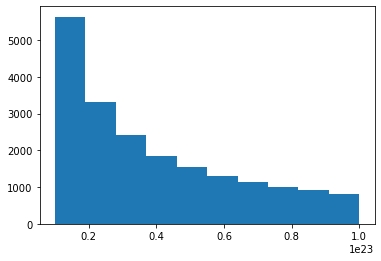

In [4]:
# Everything is in Base SI Units (kg, m, s)
# Changing Intensity, Target Thickness, Focal Distance
intensity_min = 22 # In W/m^2
intensity_max = 23
focal_distance_min = -10.0e-6
focal_distance_max = 10.0e-6
target_thickness_min = 0.5e-6
target_thickness_max = 10.0e-6
# FWHM Period and Spot Size Constant
t_FWHM_min = 40.0e-15
t_FWHM_max = 40.0e-15
spot_size_min = 2.0e-6
spot_size_max = 2.0e-6

# Randomly generate data inputs distributed uniformly in their intervals
intensities = 10**np.random.uniform(intensity_min, intensity_max, num_points)
focal_distances = np.random.uniform(focal_distance_min, focal_distance_max, num_points)
thicknesses = np.random.uniform(target_thickness_min, target_thickness_max, num_points)
time_FWHMs = np.random.uniform(t_FWHM_min, t_FWHM_max, num_points)
spot_sizes = np.random.uniform(spot_size_min, spot_size_max, num_points)

In = intensities 
# tFWHM = 40fs, spot_size = 2e-6 by default
max_en, tot_en, avg_en, efficiency, laser_en = fuchs_model(In, focal_distances, thicknesses, c1=c1, c2=c2, theta=theta, pct_noise=pct_noise)
plt.hist(intensities)

## Make Sample Plots to Explore Parameter Space

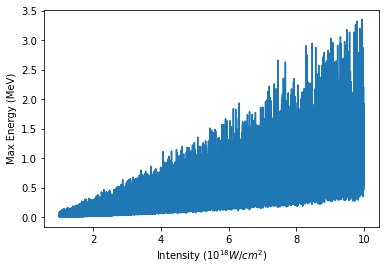

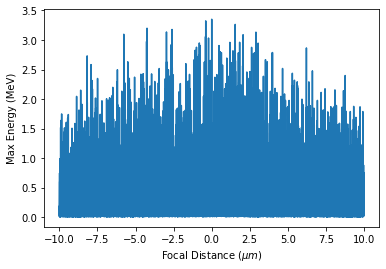

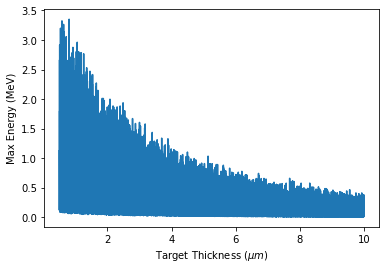

In [5]:
fig, ax = plt.subplots()
order = np.argsort(intensities)
ax.set_ylabel('Max Energy (MeV)')
ax.set_xlabel('Intensity ($10^{18} W/cm^2$)')
ax.plot(intensities[order]/10**22, max_en[order])
fig, ax = plt.subplots()
ax.set_ylabel('Max Energy (MeV)')
ax.set_xlabel('Focal Distance ($\mu m$)')
order = np.argsort(focal_distances)
ax.plot(focal_distances[order]*1e6, max_en[order])
fig, ax = plt.subplots()
ax.set_ylabel('Max Energy (MeV)')
ax.set_xlabel('Target Thickness ($\mu m$)')
order = np.argsort(thicknesses)
ax.plot(thicknesses[order]*1e6, max_en[order])

In [6]:
fname = 'fuchs_' + str(tag) + '_points_' + str(num_points) + '_noise_' + str(pct_noise)
h5_name = "datasets/Intensity/" + fname + ".h5"

h5f = h5py.File(h5_name, 'w')
h5f.create_dataset('Intensity_(W_cm2)', data= intensities*1e-4) # Convert to W/cm^2
h5f.create_dataset('Pulse_Duration_(fs)', data= time_FWHMs*1e15) # Convert to fs
h5f.create_dataset('Target_Thickness (um)', data= thicknesses*1e6) # Convert to micron
h5f.create_dataset('Spot_Size_(FWHM um)', data=spot_sizes*1e6) # Convert to micron
h5f.create_dataset('Focal_Distance_(um)', data=focal_distances*1e6) # Convert to micron
h5f.create_dataset('Max_Proton_Energy_(MeV)', data=max_en)
h5f.create_dataset('Total_Proton_Energy_(MeV)', data = tot_en)
h5f.create_dataset('Avg_Proton_Energy_(MeV)', data = avg_en)
h5f.create_dataset('laser_E(mJ)', data = laser_en*1e3)
h5f.create_dataset('ratio_proE_laserE_', data = efficiency)

h5f.close()

print('Storing to CSV file ...')
f = h5py.File(h5_name, 'r')
dsets = list(f.keys())
num_points = f[dsets[0]].shape[0]
num_columns = len(dsets)

data = np.zeros((num_points, num_columns))
for i in range(num_columns):
    data[:,i] = f[dsets[i]][:]

df = pd.DataFrame(data, columns=dsets)
df.to_csv('datasets/Intensity/' + fname + '.csv', index=False)

Storing to CSV file ...
